### Imports

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---

# Visual overview

In [189]:
# load data
df = pd.read_csv('results.csv')
df.head()

,Age,English level,Education Level,Computing Experience,Task,Selected Answer,Correct,Case Type,Time Taken (ms),Submission Timestamp
0,23,esl,undergraduate,advanced,monitor cpu usage,monitor-cpu-usage,True,kebab,26919,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...
1,23,esl,undergraduate,advanced,install software package,installSoftwarePackage,True,camel,20836,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...
2,23,esl,undergraduate,advanced,manage firewall rules,manageFirewallRules,True,camel,16048,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...
3,23,esl,undergraduate,advanced,backup database files,backupDatabaseFiles,True,camel,9786,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...
4,23,esl,undergraduate,advanced,configure network interface,configureNetworkInterface,True,camel,9116,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...


In [190]:
# prepate Timestamp field
df['Submission Timestamp'] = pd.to_datetime(df['Submission Timestamp'], format='%a %b %d %Y %H:%M:%S GMT%z (Coordinated Universal Time)')

# count unique users (Age, English level, Education Level, Computing Experience and Submission Timestamp should be the same)
df['user'] = df['Age'].astype(str) + df['English level'] + df['Education Level'] + df['Computing Experience'] + df['Submission Timestamp'].astype(str)
df['user'] = df['user'].apply(lambda x: hash(x))
df['user'] = df['user'].astype(str)
print('Unique users:', len(df['user'].unique()))

Unique users: 16


In [191]:
number_of_tests_per_user = df.shape[0] / df['user'].nunique()
print('Number of tests per user:', int(number_of_tests_per_user))

Number of tests per user: 30


---

### Outliers check

In [192]:
df_test = df.copy()
# Sort by time taken
df_test = df_test.sort_values(by='Time Taken (ms)', ascending=False)
df_test = df_test.reset_index(drop=True)
# Top 5 unique slowest users
df_test.head(5)

,Age,English level,Education Level,Computing Experience,Task,Selected Answer,Correct,Case Type,Time Taken (ms),Submission Timestamp,user
0,16,efl,hs,moderate,monitor cpu usage,monitor-cpu-usage,True,kebab,52166,2024-12-03 19:47:32+00:00,7915502607060936945
1,23,efl,undergraduate,moderate,monitor cpu usage,monitor-cpu-usage,True,kebab,43185,2024-12-03 17:58:41+00:00,-3441590266112812801
2,20,efl,undergraduate,advanced,monitor cpu usage,monitor-cpu-usage,True,kebab,40184,2024-12-12 16:53:07+00:00,4299494398330637546
3,23,efl,undergraduate,moderate,run diagnostic tests,run-diagnostic-tests,True,kebab,28959,2024-12-03 17:58:41+00:00,-3441590266112812801
4,23,esl,undergraduate,advanced,monitor cpu usage,monitor-cpu-usage,True,kebab,26919,2024-12-03 17:47:56+00:00,-7399061605207090786


*These users may have started the test without looking at the manuals*

---

### Demographic data

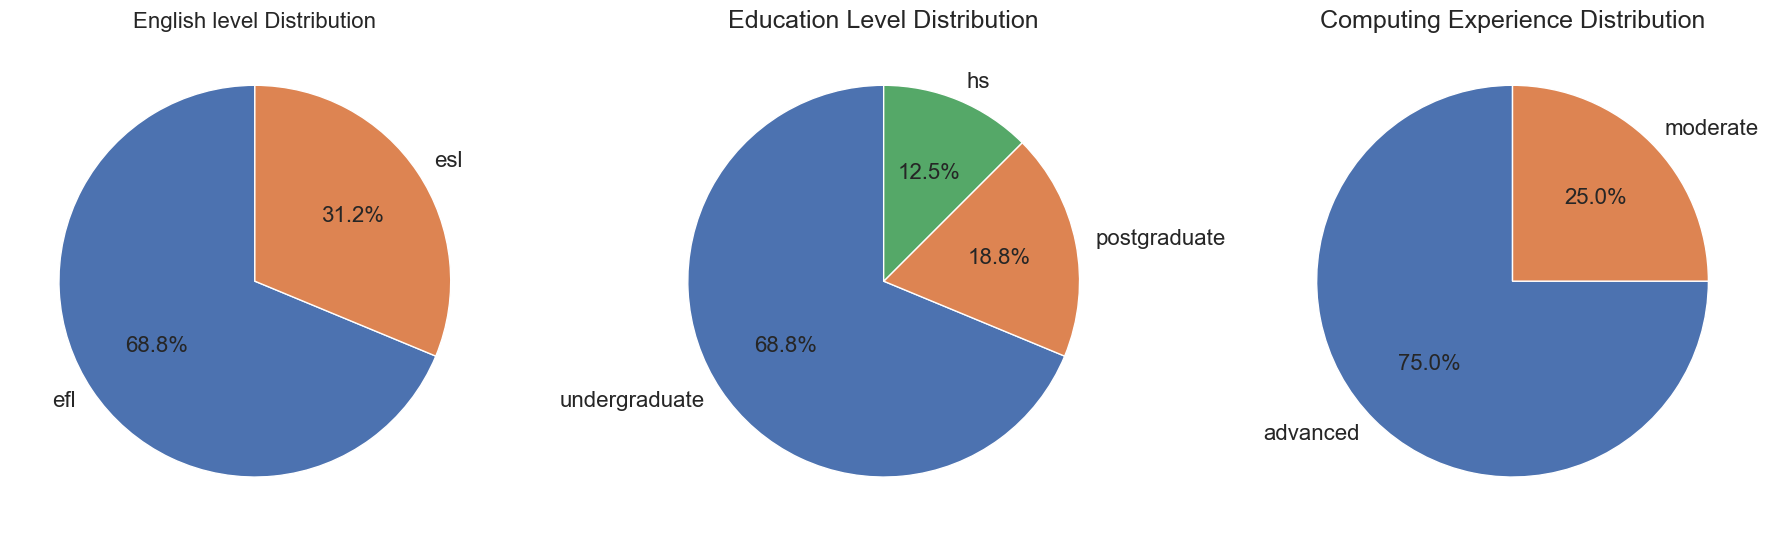

In [193]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

df['English level'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[0], textprops={'fontsize': 16})
axes[0].set_title('English level Distribution', fontsize=16)
axes[0].set_ylabel('')

df['Education Level'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[1], textprops={'fontsize': 16})
axes[1].set_title('Education Level Distribution', fontsize=18)
axes[1].set_ylabel('')

df['Computing Experience'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[2], textprops={'fontsize': 16})
axes[2].set_title('Computing Experience Distribution', fontsize=18)
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()


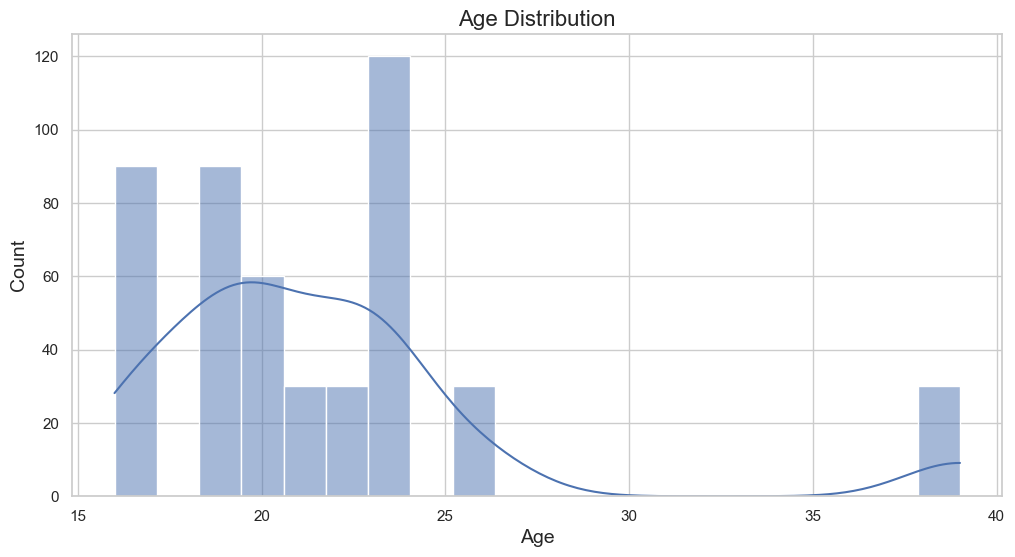

In [194]:
# Age distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

---

### General for Case Type

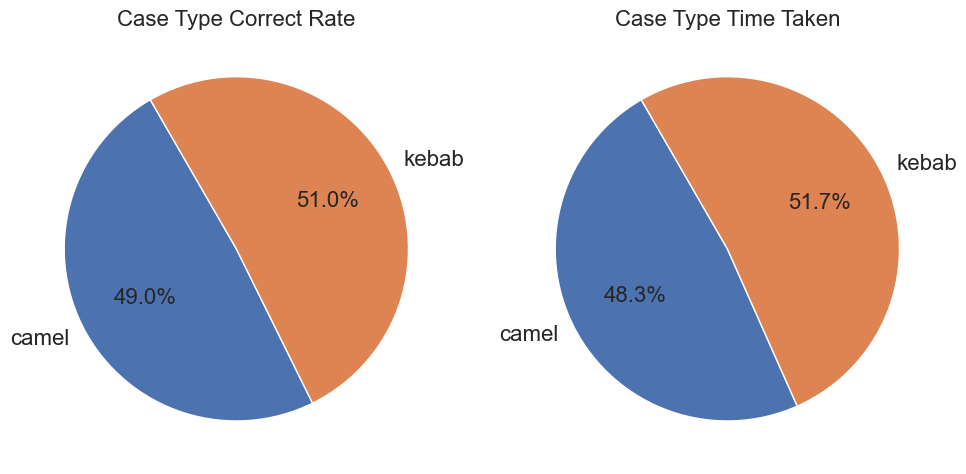

In [195]:
# Display Case type and their correct rate
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

df.groupby('Case Type')['Correct'].mean().plot.pie(autopct='%1.1f%%', startangle=120, ax=axes[0], textprops={'fontsize': 16})
axes[0].set_title('Case Type Correct Rate', fontsize=16)
axes[0].set_ylabel('')

df.groupby('Case Type')['Time Taken (ms)'].mean().plot.pie(autopct='%1.1f%%', startangle=120, ax=axes[1], textprops={'fontsize': 16})
axes[1].set_title('Case Type Time Taken', fontsize=16)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


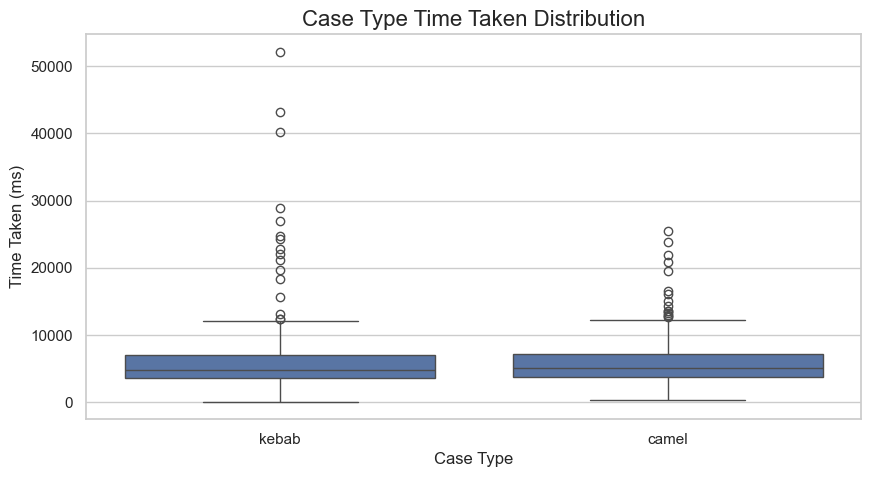

In [196]:
# Display Case type and their min, max, mean time taken
plt.figure(figsize=(10, 5))
sns.boxplot(x='Case Type', y='Time Taken (ms)', data=df)
plt.title('Case Type Time Taken Distribution', fontsize=16)
plt.show()

---

### Tasks

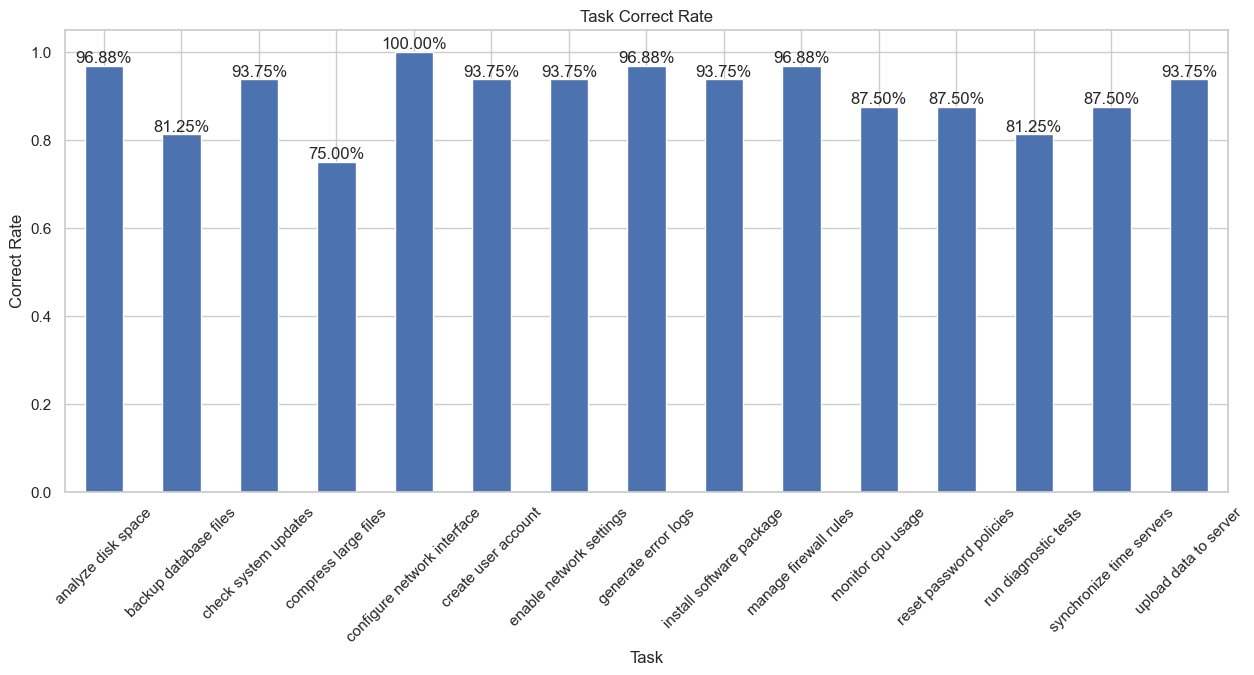

In [197]:
# Display Tasks and their correct rate
df['Correct'] = df['Correct'].astype(int)
plt.figure(figsize=(15, 6))
df.groupby('Task')['Correct'].mean().plot.bar()
plt.title('Task Correct Rate')
plt.xlabel('Task')
plt.ylabel('Correct Rate')
plt.xticks(rotation=45)

df_correct_rate = df.groupby('Task')['Correct'].mean()
for i, (task, rate) in enumerate(df_correct_rate.items()):
  plt.annotate(f'{rate:.2%}', xy=(i, rate), ha='center', va='bottom')

plt.show()

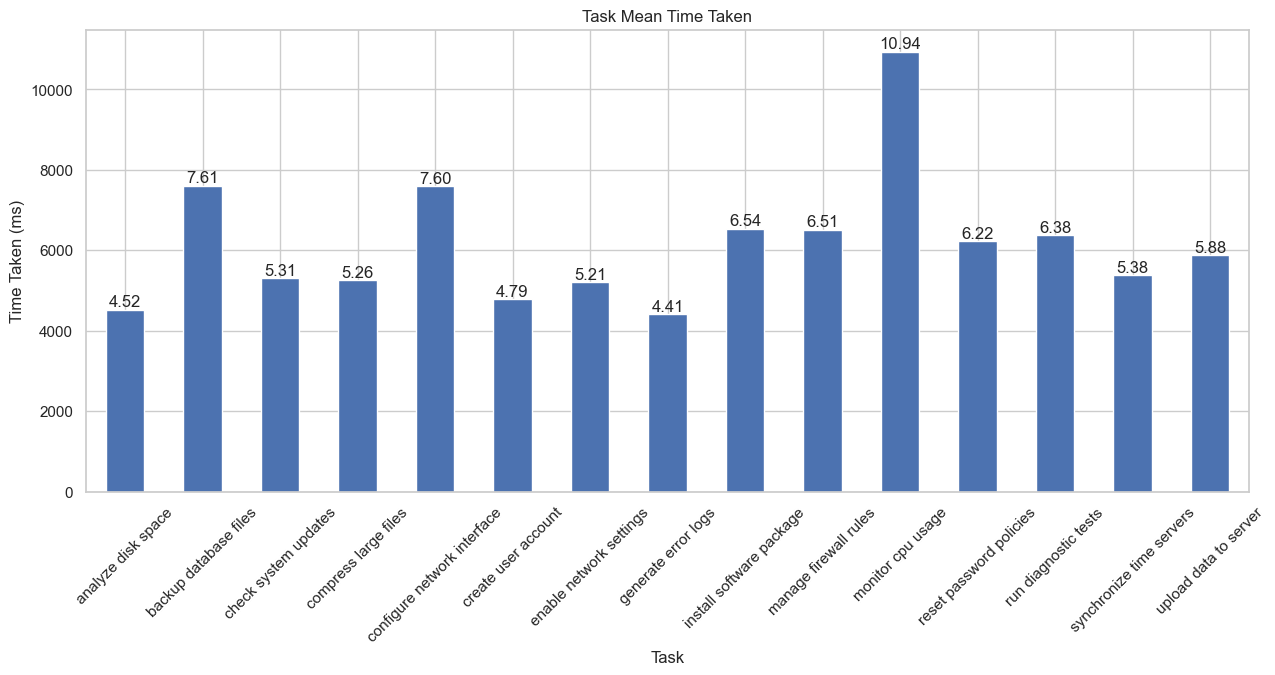

In [198]:
# Display Tasks and their time taken (ms)
plt.figure(figsize=(15, 6))
df.groupby('Task')['Time Taken (ms)'].mean().plot.bar()
plt.title('Task Mean Time Taken')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)

df_time_taken = df.groupby('Task')['Time Taken (ms)'].mean()
for i, (task, time) in enumerate(df_time_taken.items()):
  plt.annotate(f'{time / 1000:.2f}', xy=(i, time), ha='center', va='bottom')

plt.show()

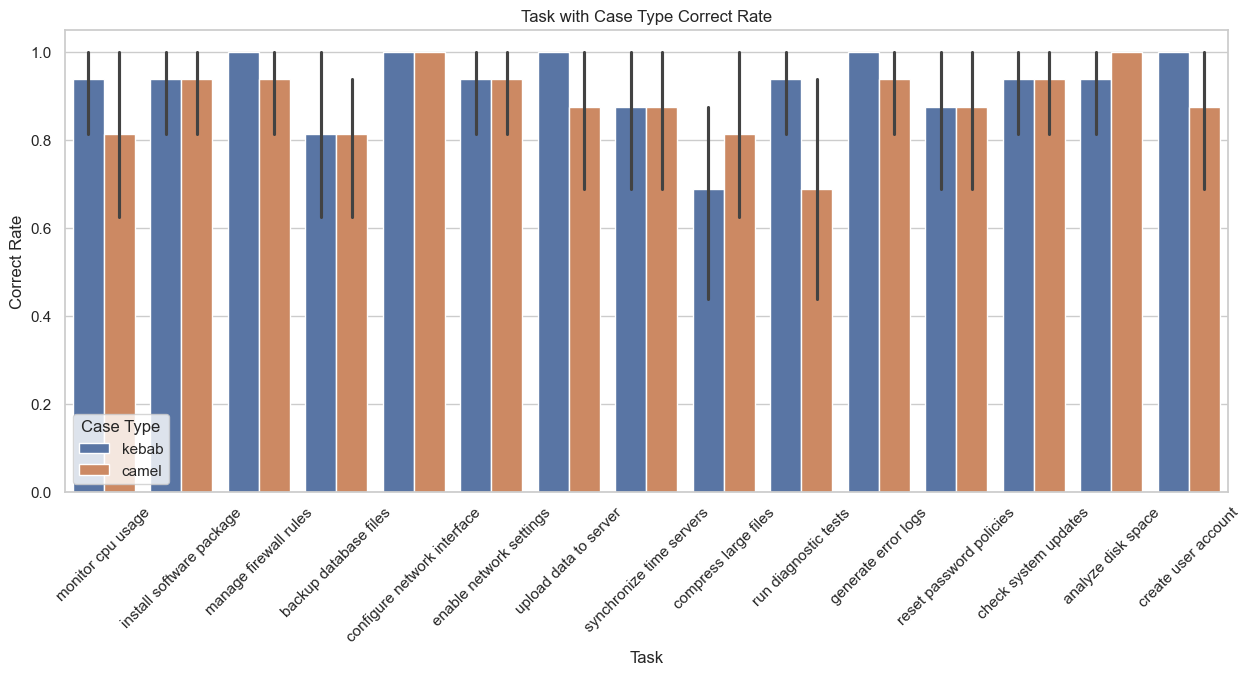

In [199]:
# Display Tasks with Case Type and their correct rate
plt.figure(figsize=(15, 6))
sns.barplot(x='Task', y='Correct', hue='Case Type', data=df)
plt.title('Task with Case Type Correct Rate')
plt.xlabel('Task')
plt.ylabel('Correct Rate')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

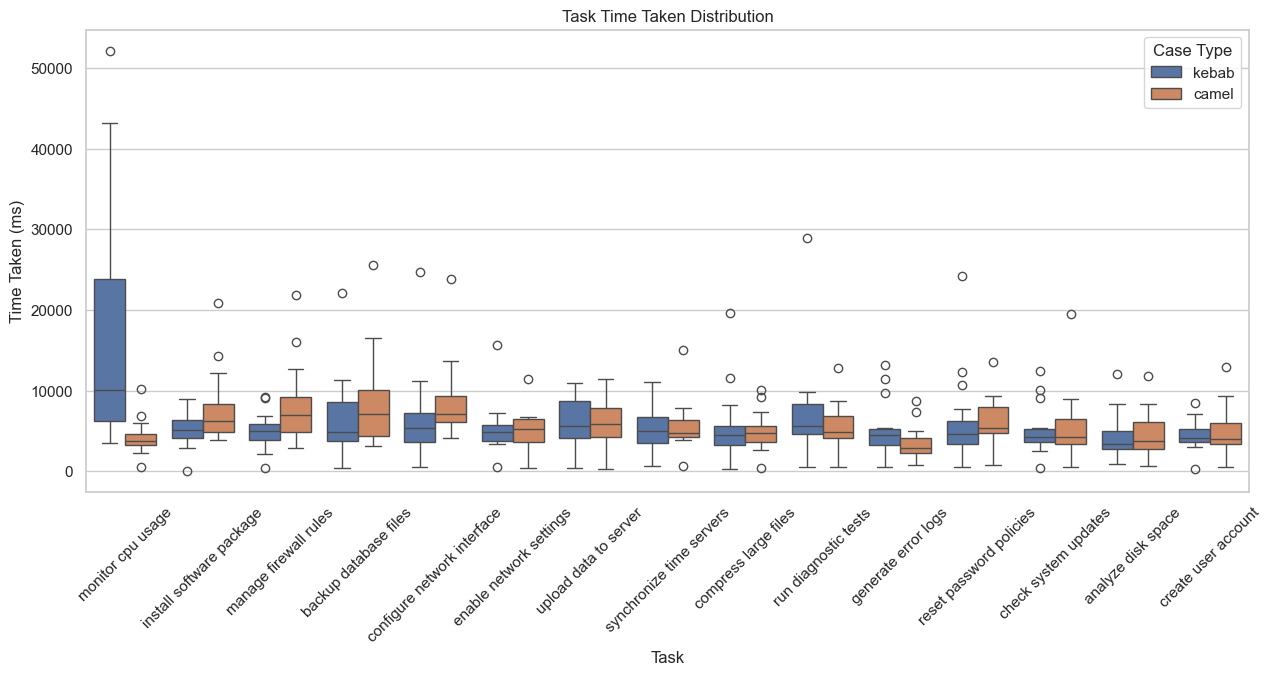

In [200]:
# Display Tasks with Case type and time taken (min, max, mean)
plt.figure(figsize=(15, 6))
sns.boxplot(x='Task', y='Time Taken (ms)', hue='Case Type', data=df)
plt.title('Task Time Taken Distribution')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

---

### Answers

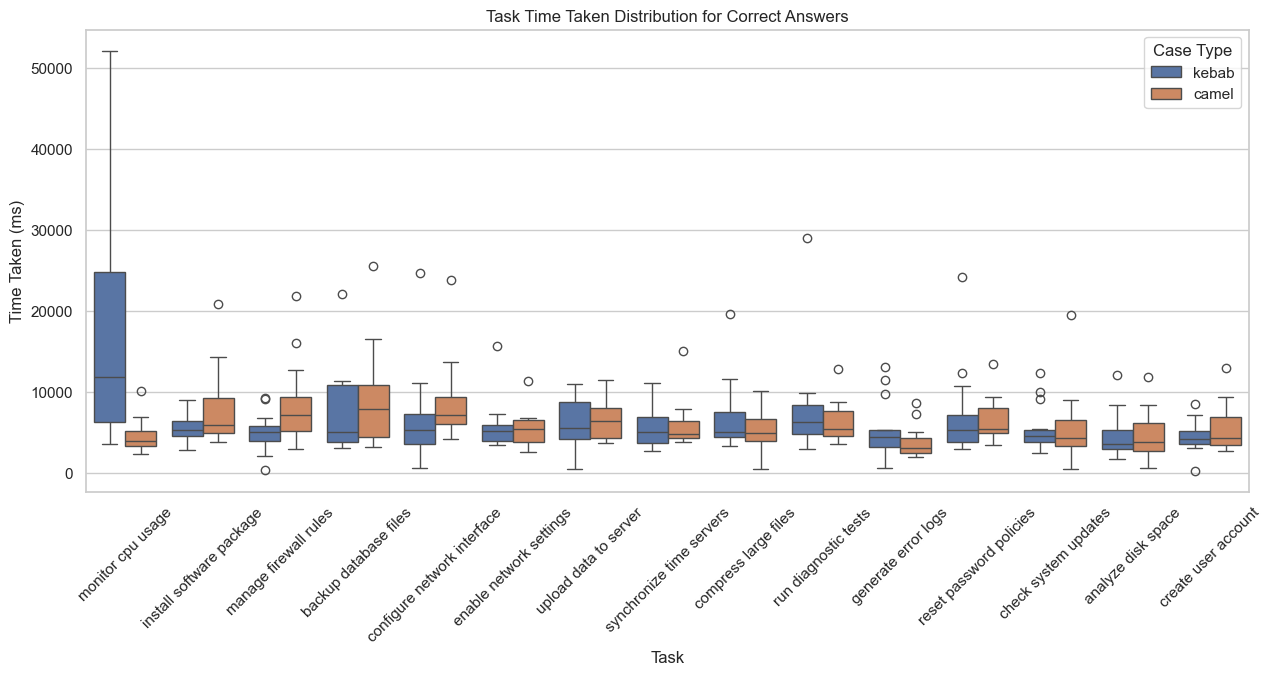

In [201]:
# Display Tasks with Case type and time taken (min, max, mean) but only for correct answers
plt.figure(figsize=(15, 6))
sns.boxplot(x='Task', y='Time Taken (ms)', hue='Case Type', data=df[df['Correct'] == 1])
plt.title('Task Time Taken Distribution for Correct Answers')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

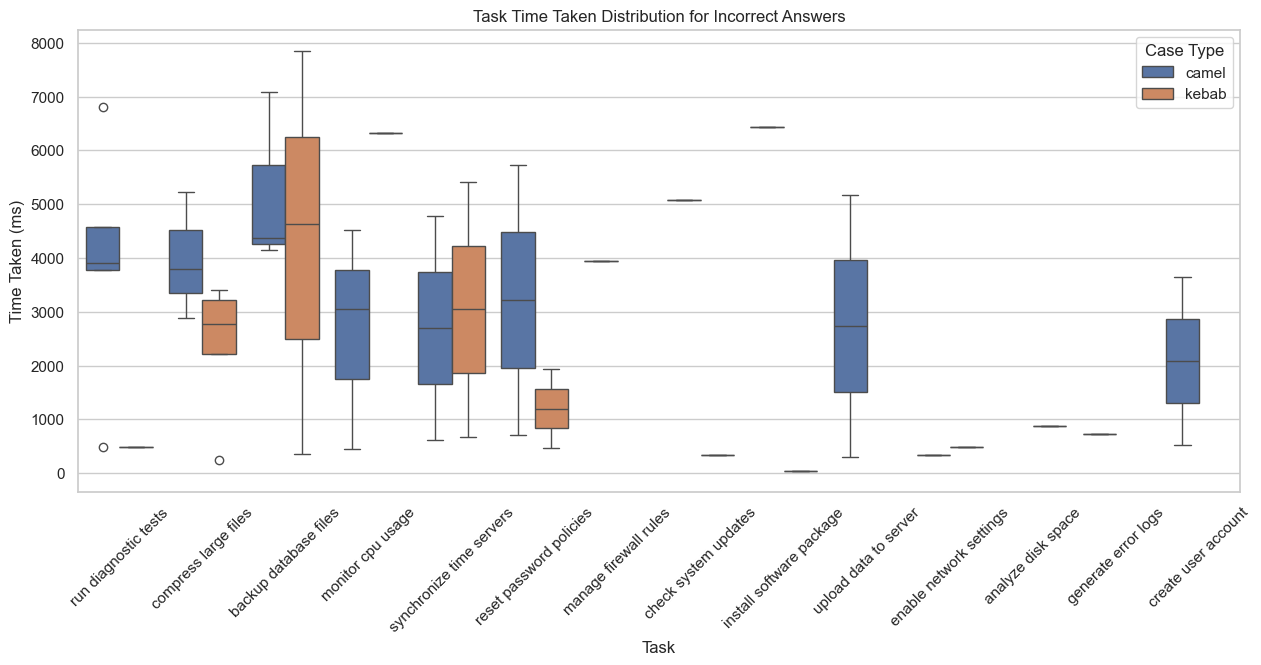

In [202]:
# Display Tasks with Case type and time taken (min, max, mean) but only for incorrect answers
plt.figure(figsize=(15, 6))
sns.boxplot(x='Task', y='Time Taken (ms)', hue='Case Type', data=df[df['Correct'] == 0])
plt.title('Task Time Taken Distribution for Incorrect Answers')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

---

### Demographic 

In [203]:
demographics = df[['Age', 'English level', 'Education Level', 'Computing Experience']]

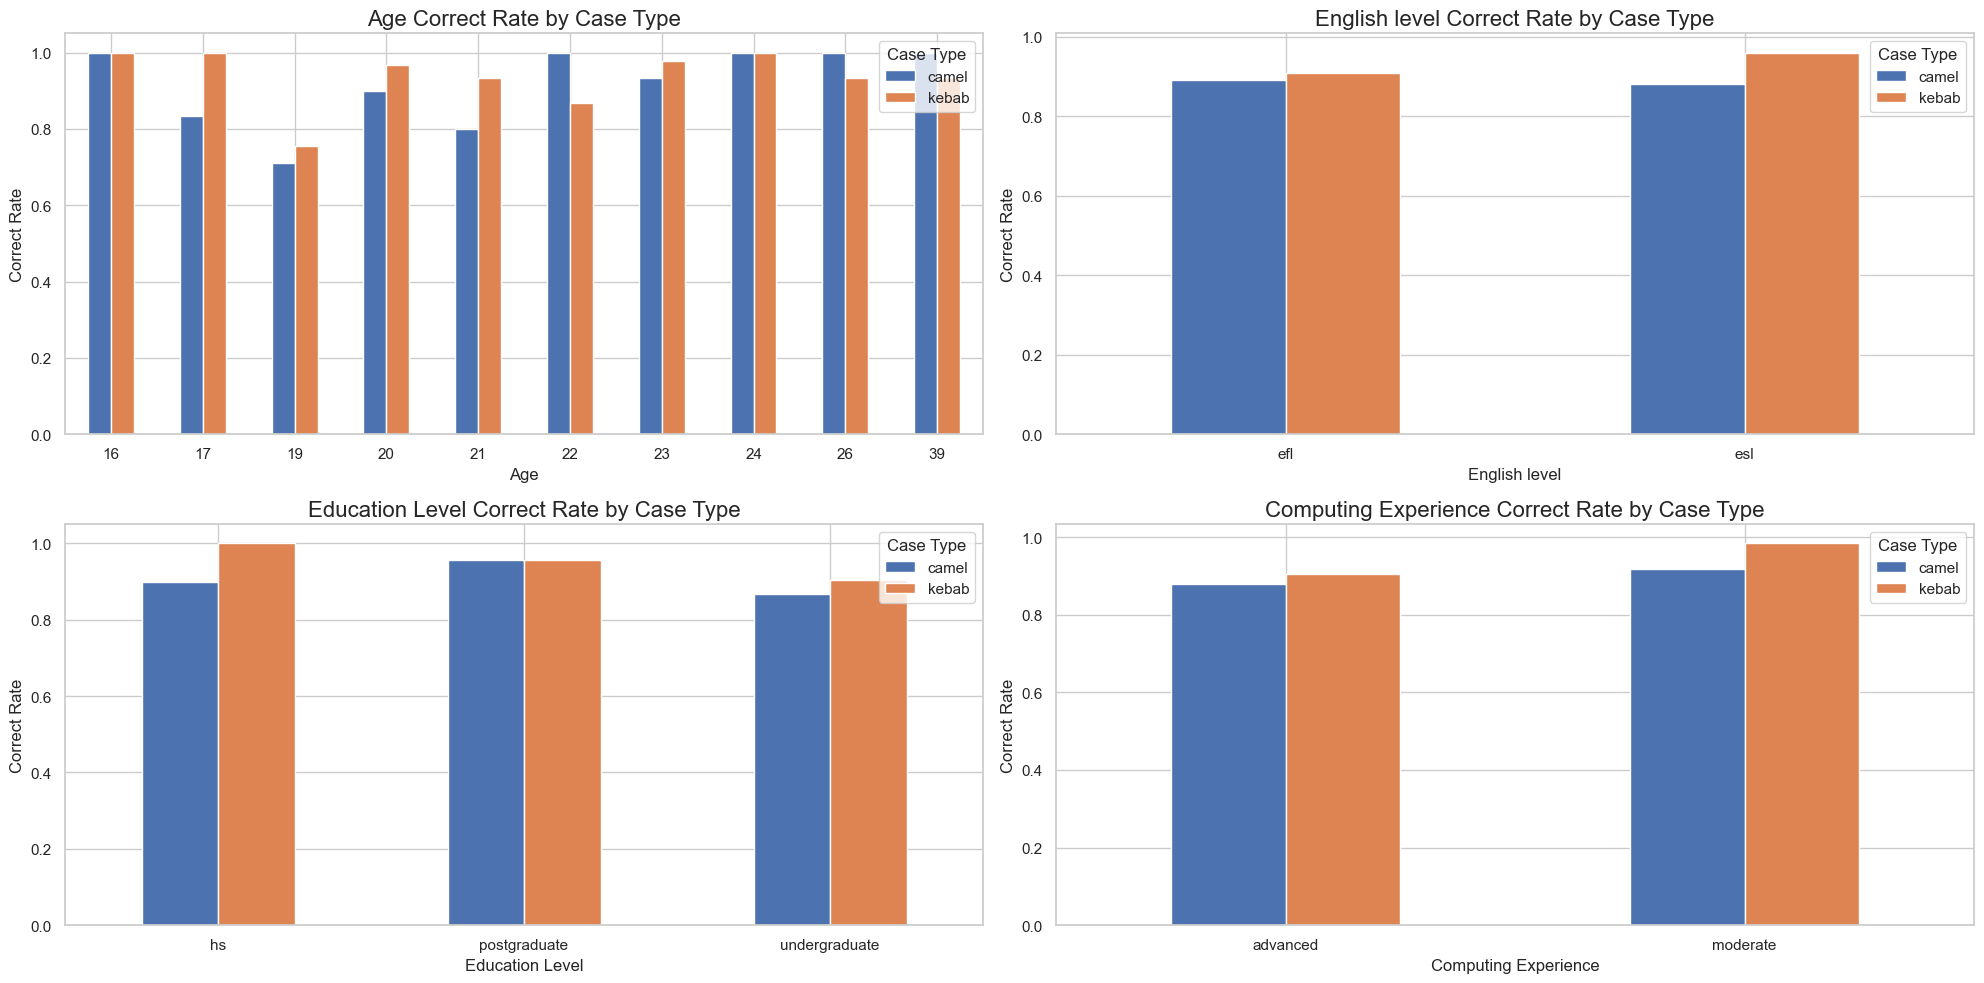

In [204]:
# Display distribution of Age, English level, Education Level, Computing Experience for correct rate
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

df.groupby(['Age', 'Case Type'])['Correct'].mean().unstack().plot.bar(ax=axes[0, 0])
axes[0, 0].set_title('Age Correct Rate by Case Type', fontsize=16)
axes[0, 0].set_ylabel('Correct Rate')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

df.groupby(['English level', 'Case Type'])['Correct'].mean().unstack().plot.bar(ax=axes[0, 1])
axes[0, 1].set_title('English level Correct Rate by Case Type', fontsize=16)
axes[0, 1].set_ylabel('Correct Rate')
axes[0, 1].set_xlabel('English level')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

df.groupby(['Education Level', 'Case Type'])['Correct'].mean().unstack().plot.bar(ax=axes[1, 0])
axes[1, 0].set_title('Education Level Correct Rate by Case Type', fontsize=16)
axes[1, 0].set_ylabel('Correct Rate')
axes[1, 0].set_xlabel('Education Level')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

df.groupby(['Computing Experience', 'Case Type'])['Correct'].mean().unstack().plot.bar(ax=axes[1, 1])
axes[1, 1].set_title('Computing Experience Correct Rate by Case Type', fontsize=16)
axes[1, 1].set_ylabel('Correct Rate')
axes[1, 1].set_xlabel('Computing Experience')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


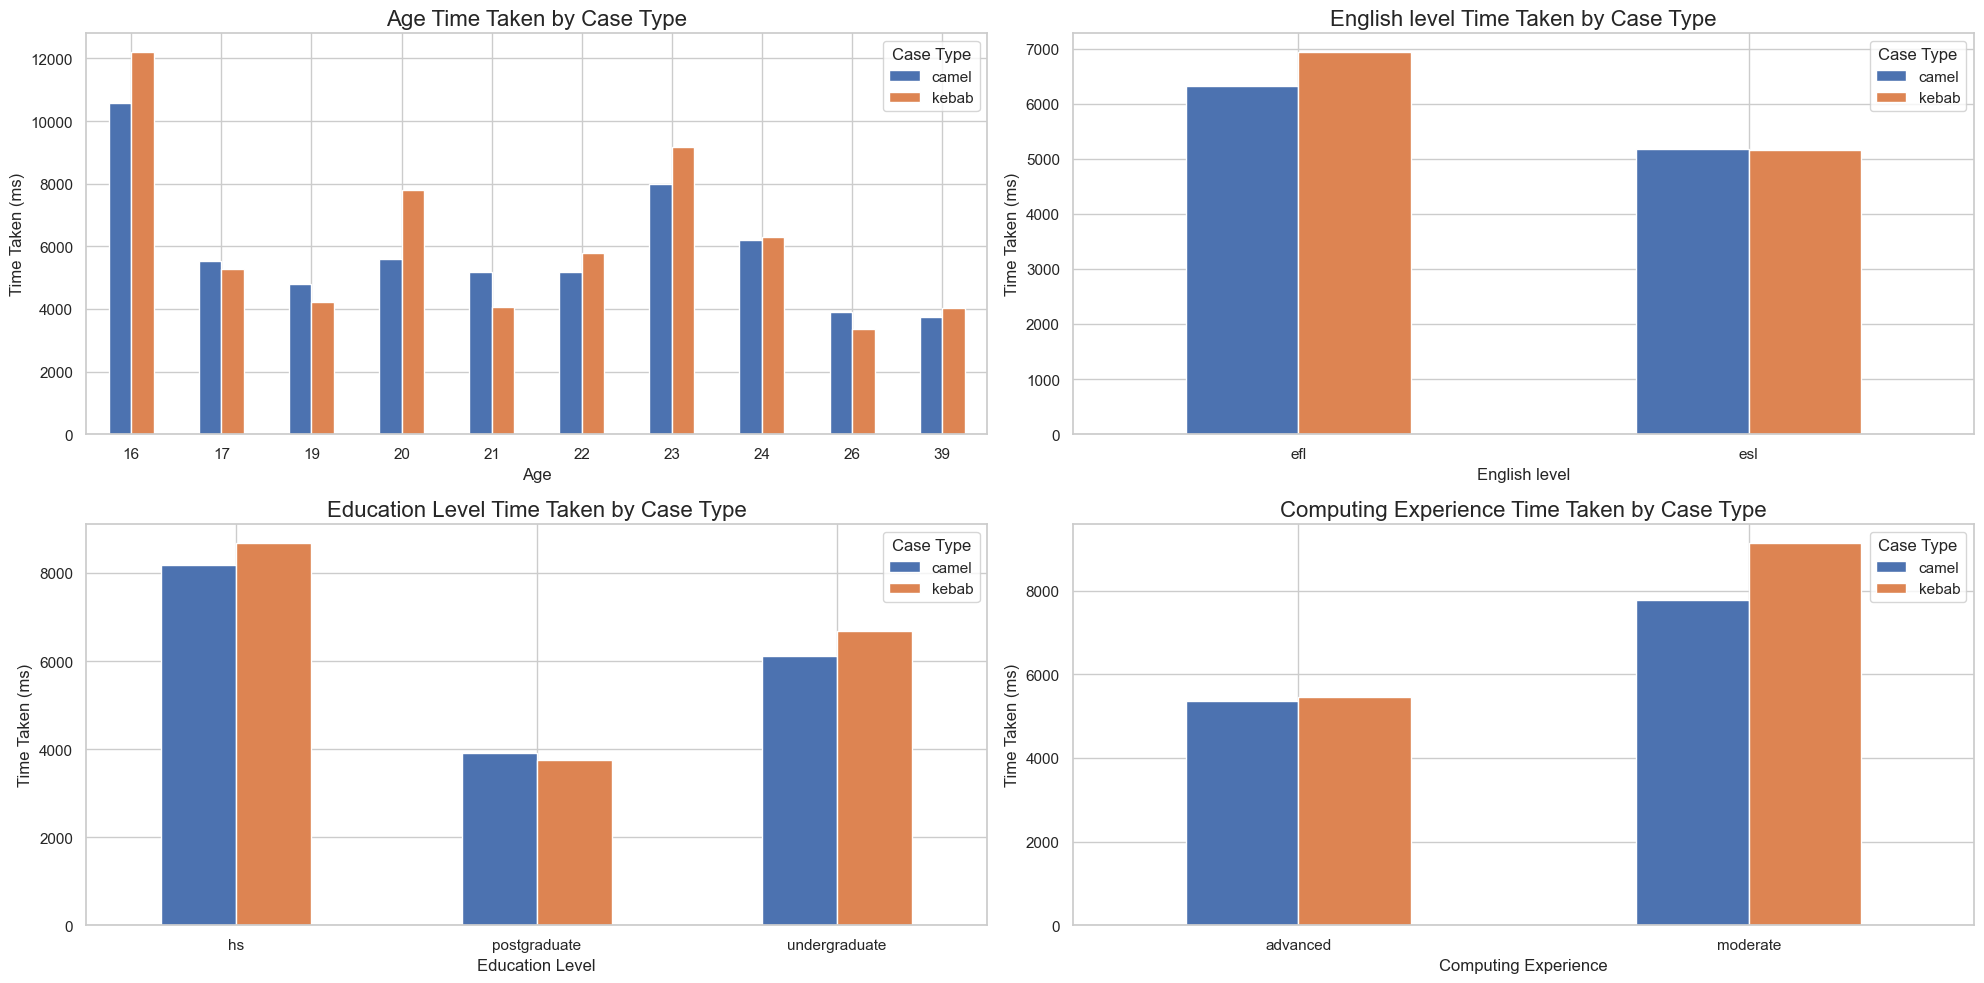

In [205]:
# Display distribution of Age, English level, Education Level, Computing Experience for time taken
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

df.groupby(['Age', 'Case Type'])['Time Taken (ms)'].mean().unstack().plot.bar(ax=axes[0, 0])
axes[0, 0].set_title('Age Time Taken by Case Type', fontsize=16)
axes[0, 0].set_ylabel('Time Taken (ms)')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

df.groupby(['English level', 'Case Type'])['Time Taken (ms)'].mean().unstack().plot.bar(ax=axes[0, 1])
axes[0, 1].set_title('English level Time Taken by Case Type', fontsize=16)
axes[0, 1].set_ylabel('Time Taken (ms)')
axes[0, 1].set_xlabel('English level')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

df.groupby(['Education Level', 'Case Type'])['Time Taken (ms)'].mean().unstack().plot.bar(ax=axes[1, 0])
axes[1, 0].set_title('Education Level Time Taken by Case Type', fontsize=16)
axes[1, 0].set_ylabel('Time Taken (ms)')
axes[1, 0].set_xlabel('Education Level')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

df.groupby(['Computing Experience', 'Case Type'])['Time Taken (ms)'].mean().unstack().plot.bar(ax=axes[1, 1])
axes[1, 1].set_title('Computing Experience Time Taken by Case Type', fontsize=16)
axes[1, 1].set_ylabel('Time Taken (ms)')
axes[1, 1].set_xlabel('Computing Experience')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

---